# Transfer learning
TL of Alexnet with XGBoost as classifier applied to handwritten digits dataset

In [119]:
import os
from IPython.display import display, clear_output
import shutil
import random

from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

### Make train and test directories

In [69]:
# Create train and test folders
for train_test_dir in ['train','test']:
    try:
        os.mkdir('data/'+train_test_dir)
    except:
        pass

In [70]:
# Define training and test data directories
data_dir = 'data/'
dataset_dir = os.path.join(data_dir, 'dataset/')
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [71]:
for subdir in os.listdir(dataset_dir):
    l = os.listdir(dataset_dir+subdir)
    train, test, _ , _ = train_test_split(l,[subdir for i in range(len(l))],test_size=0.2, random_state=42)
    
    # Create subdirectories in test and train folders
    for train_test_dir in ['train/','test/']:
        try:
            os.mkdir('data/'+train_test_dir+subdir)
        except:
            pass
    
    # Populate train and test folders
    print('Populate training set for class {}'.format(subdir))
    for item in [dataset_dir+subdir+'/'+f for f in train] :
        shutil.copy(item, train_dir+subdir)

    print('Populate test set for class {}'.format(subdir))
    for item in [dataset_dir+subdir+'/'+f for f in test] :
        shutil.copy(item, test_dir+subdir)

Populate training set for class 0
Populate test set for class 0
Populate training set for class 1
Populate test set for class 1
Populate training set for class 2
Populate test set for class 2
Populate training set for class 3
Populate test set for class 3
Populate training set for class 4
Populate test set for class 4
Populate training set for class 5
Populate test set for class 5
Populate training set for class 6
Populate test set for class 6
Populate training set for class 7
Populate test set for class 7
Populate training set for class 8
Populate test set for class 8
Populate training set for class 9
Populate test set for class 9


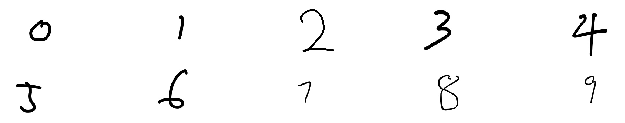

In [114]:
fig,ax = plt.subplots(figsize=(12,2))

lines=2
cols = 5
i=1

# sample from train dir
for subdir in os.listdir(train_dir):
    sample = random.sample(os.listdir(train_dir+subdir),1)[0]
    im = Image.open(train_dir+subdir+'/'+sample)
    plt.subplot(lines,cols,i)
    plt.imshow(np.asarray(im))
    plt.axis('off')
    i+=1

### Extract features out of convolutional layer

In [72]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Load model
conv_layer = models.alexnet(pretrained=True)
print(conv_layer.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [73]:
# Image to tensor
def preprocess(img):  
    img = img.resize((224,224)).convert('RGB')
    tensor = transforms.ToTensor()(img)
    return tensor

# Load training data and fit to alexnet data
train = datasets.ImageFolder(train_dir, transform=preprocess)
test = datasets.ImageFolder(test_dir, transform=preprocess)

print('Num training images: ', len(train))
print('Num test images: ', len(test))

Num training images:  4239
Num test images:  1065


In [74]:
# generate data loaders
batch_size = 20
num_workers = 0
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [84]:
def extract_features(data_loader, output_path):
    
    num_batch = len(data_loader)
    count = 0
    try:
        os.remove(output_path) # to erase previous version as it is mode 'a'
    except FileNotFoundError:
        pass

    # extract features on a single line for each image
    for batch, labels in data_loader:

        feature_list = []
        label_list = []

        for idx, img in enumerate(batch):
            features_extracted = conv_layer.features(img.reshape((1, 3, 224, 224)))
            feature_list.append(features_extracted.detach().numpy().reshape((256 * 6 * 6)))
            label_list.append(labels[idx].item())

        row_features = pd.DataFrame(data=feature_list)
        row_label = pd.DataFrame(data=label_list, columns=['label'])
        row = pd.concat([row_features, row_label], axis=1)  
        row.to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)
        count += 1

        # display progress
        clear_output(wait=True)
        file_size = os.path.getsize(output_path)
        print('batch %d/%d, %s file size: %.3f Mo'%(count, num_batch, output_path,  file_size/10**6))
        print('Forectased csv size = %.2f Mo'%(num_batch/count*file_size/10**6))

In [85]:
%%time 
train_path = 'data/train_features.csv'
extract_features(train_loader, train_path)

batch 212/212, data/train_features.csv file size: 262.088 Mo
Forectased csv size = 262.09 Mo
Wall time: 11min 19s


In [86]:
%%time 
test_path = 'data/test_features.csv'
extract_features(test_loader, test_path)

batch 54/54, data/test_features.csv file size: 65.818 Mo
Forectased csv size = 65.82 Mo
Wall time: 2min 40s


## Train XGB classifier

In [115]:
# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = np.array(train_df[train_df.columns[~train_df.columns.isin(['label'])]])
y_train = np.array(train_df['label'])
X_test = np.array(test_df[test_df.columns[~test_df.columns.isin(['label'])]])
y_test = np.array(test_df['label'])

In [116]:
# Size of sets
print("X Train set:",X_train.shape)
print("y Train set:",y_train.shape)
print("X Test set:",X_test.shape)
print("y Test set:",y_test.shape)

X Train set: (4239, 9216)
y Train set: (4239,)
X Test set: (1065, 9216)
y Test set: (1065,)


In [125]:
%%time
# Cross-validator 
sss = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 42)

# Define classifier
#clf = xgb.XGBClassifier()

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ('XGB',clf)
])   

# parameters to tune 
param_grid = {
    #'XGB__n_estimators': [100, 150],
    #'XGB__learning_rate': [0.01, 0.001]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training classifier
grid.fit(X_train, y_train)

# best classifier
clf = grid.best_estimator_

# predicition with the classifier
y_pred = clf.predict(X_test)

# print grid best parameters
print(grid.best_params_)

# save classifier
with open("data/classifier.pkl", 'wb') as fid:
    pk.dump(clf, fid)

# classification report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.5s finished


{}
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       119
           1       0.97      0.81      0.88       113
           2       0.72      0.91      0.80        87
           3       0.68      0.75      0.72       109
           4       0.71      0.84      0.77       106
           5       0.65      0.72      0.68        87
           6       0.74      0.71      0.72       117
           7       0.84      0.77      0.80       107
           8       0.71      0.66      0.68       111
           9       0.81      0.75      0.78       109

    accuracy                           0.76      1065
   macro avg       0.76      0.76      0.76      1065
weighted avg       0.77      0.76      0.76      1065

Wall time: 13.3 s


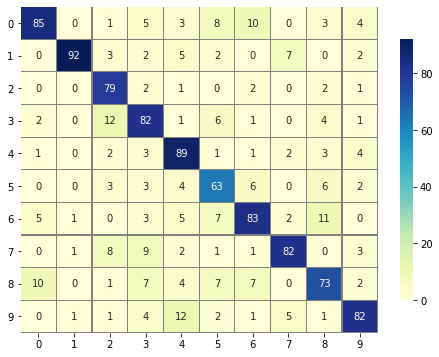

In [156]:
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.columns = os.listdir('data/train')
cm.index = os.listdir('data/train')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d',
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right');

### Show predictions on test sample

In [127]:
# Load model
conv_layer = models.alexnet(pretrained=True)
with open("data/classifier.pkl", 'rb') as fid:
    clf_trained = pk.load(fid)

In [148]:
def make_prediction(img):
    features_extracted = conv_layer.features(preprocess(img).reshape((1, 3, 224, 224)))
    conv_layer_output = features_extracted.detach().numpy().reshape((256 * 6 * 6))
    return clf_trained.predict([conv_layer_output])[0]

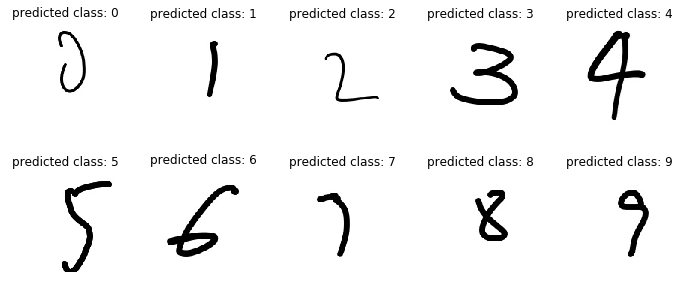

In [154]:
fig,ax = plt.subplots(figsize=(12,5))

lines=2
cols = 5
i=1

# prediction on sample from train dir
for subdir in os.listdir(train_dir):
    sample = random.sample(os.listdir(train_dir+subdir),1)[0]
    im = Image.open(train_dir+subdir+'/'+sample)
    predicted_class = make_prediction(im)
    plt.subplot(lines,cols,i)
    plt.imshow(np.asarray(im))
    plt.title('predicted class: {}'.format(predicted_class))
    plt.axis('off')
    i+=1